# Compare Hippocampal Subfield Volumes Computed By ASHS & Freesurfer

<font color='red'>NOTE: Dummy data with pseudo volumes</font>

In [1]:
SUBJECTS_DIR = '../tests/subjects'
SUBJECT = 'bert'

## Read Volume Files

In [2]:
import os, pandas
from freesurfer_volume_reader import SubfieldVolumeFile, ashs, freesurfer

def read_volume_file(volume_file: SubfieldVolumeFile) -> pandas.DataFrame:
    volume_frame = volume_file.read_volumes_dataframe()
    volume_frame['source_basename'] = os.path.basename(volume_file.absolute_path)
    return volume_frame

def find_read_volume_files(source_type: str, volume_type) -> pandas.DataFrame:
    volume_files = filter(lambda f: f.subject == SUBJECT, volume_type.find(SUBJECTS_DIR))
    frame = pandas.concat(map(read_volume_file, volume_files))
    frame['source_type'] = source_type
    return frame

volume_frame = pandas.concat([find_read_volume_files('ASHS', ashs.HippocampalSubfieldsVolumeFile),
                              find_read_volume_files('Freesurfer', freesurfer.HippocampalSubfieldsVolumeFile)],
                             sort=False)
volume_frame[['subject', 'source_type', 'source_basename']].drop_duplicates() \
    .sort_values(by='source_basename').reset_index(drop=True)

,subject,source_type,source_basename
0,bert,ASHS,bert_left_corr_nogray_volumes.txt
1,bert,ASHS,bert_left_corr_usegray_volumes.txt
2,bert,ASHS,bert_left_heur_volumes.txt
3,bert,ASHS,bert_right_corr_nogray_volumes.txt
4,bert,Freesurfer,lh.hippoSfVolumes-T1-T2.v10.txt
5,bert,Freesurfer,lh.hippoSfVolumes-T1.v10.txt


## Select Subfields Provided by Both ASHS & Freesurfer

In [3]:
volume_frame[['source_type', 'subfield']].drop_duplicates().reset_index(drop=True)

,source_type,subfield
0,ASHS,CA1
1,ASHS,CA2+3
2,ASHS,DG
3,ASHS,ERC
4,ASHS,PHC
5,ASHS,PRC
6,ASHS,SUB
7,Freesurfer,Hippocampal_tail
8,Freesurfer,subiculum
9,Freesurfer,CA1


In [4]:
volume_frame['subfield'].replace('SUB', 'subiculum', inplace=True)

common_subfields = set.intersection(*(set(volume_frame[volume_frame['source_type'] == src]['subfield'].unique())
                                      for src in volume_frame['source_type'].unique()))
common_subfields

{'CA1', 'subiculum'}

## Compare Volumes

In [5]:
common_subfields_frame = volume_frame[volume_frame['subfield'].isin(common_subfields)].copy()

def generate_segmentation_mode(row) -> str:
    if row['source_type'] == 'ASHS':
        return 'ASHS T1 & T2 {}'.format(row['correction'] or 'heur')
    if row['source_type'] == 'Freesurfer':
        abrev_analysis_id = row['analysis_id'].split('_')[0][:7] if row['analysis_id'] else None
        return 'Freesurfer ' + ' & '.join(filter(None, ['T1' if row['T1_input'] else None, abrev_analysis_id]))
    raise TypeError(row['source_type'])


common_subfields_frame['segmentation_mode'] = common_subfields_frame.apply(generate_segmentation_mode, axis=1)

common_subfields_frame.pivot_table(values='volume_mm^3',
                                   index=['subfield', 'hemisphere'],
                                   columns='segmentation_mode')

segmentation_mode     ASHS T1 & T2 heur  ASHS T1 & T2 nogray  \
subfield  hemisphere                                           
CA1       left                  678.903              678.901   
          right                     NaN              678.903   
subiculum left                  457.781              457.789   
          right                     NaN              457.781   

segmentation_mode     ASHS T1 & T2 usegray  Freesurfer T1  Freesurfer T1 & T2  
subfield  hemisphere                                                           
CA1       left                     678.902      34.567891           44.567891  
          right                        NaN            NaN                 NaN  
subiculum left                     457.780     234.567891          244.567891  
          right                        NaN            NaN                 NaN

<font color='red'>NOTE: Dummy data with pseudo volumes</font>

<IPython.core.display.Javascript object>


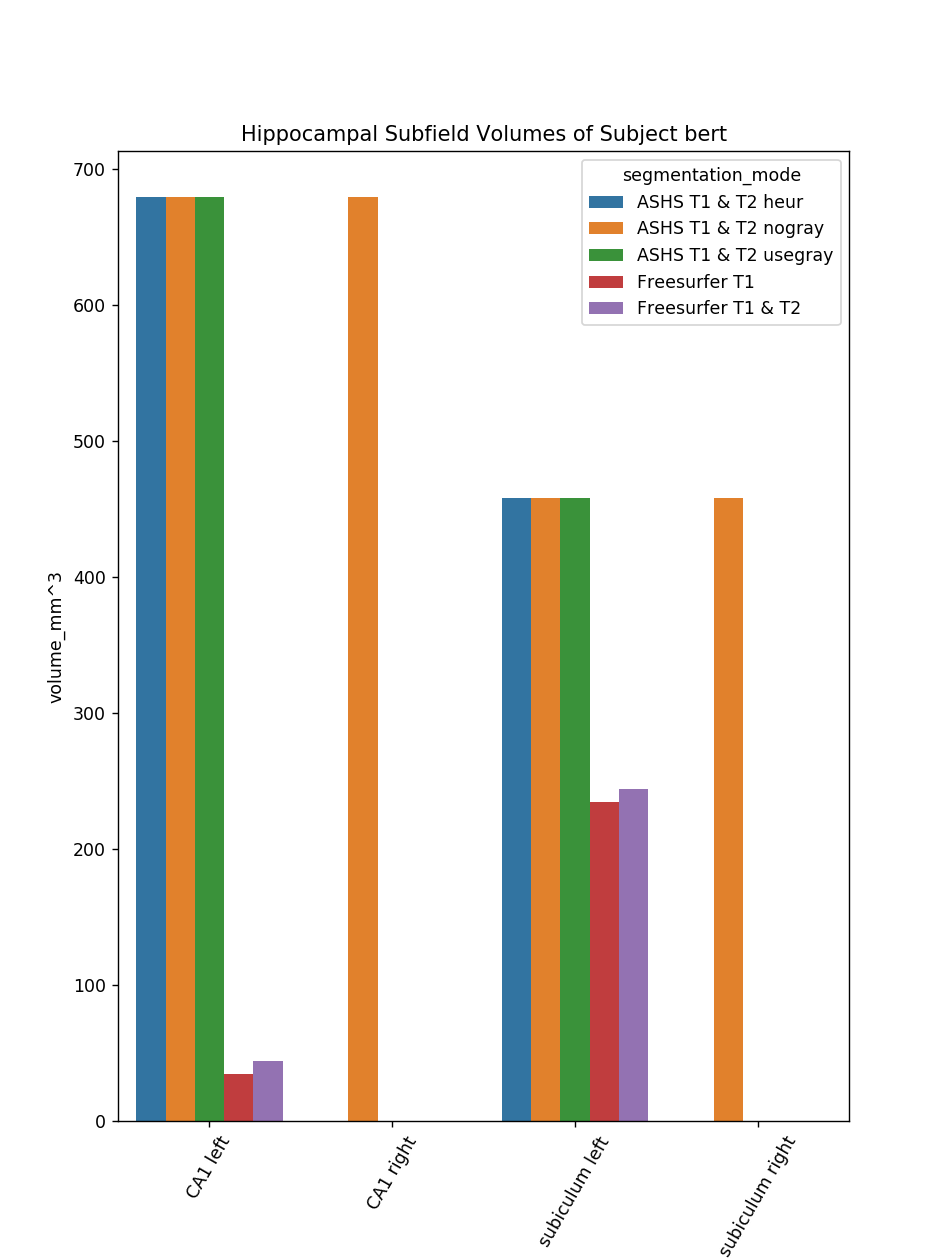

In [6]:
common_subfields_frame['subfield_hemisphere'] = common_subfields_frame.apply(
    lambda row: row['subfield'] + ' ' + row['hemisphere'], axis=1)

import seaborn
%matplotlib notebook
ax = seaborn.barplot(data=common_subfields_frame.sort_values(['subfield_hemisphere', 'segmentation_mode']),
                     x='subfield_hemisphere',
                     y='volume_mm^3',
                     hue='segmentation_mode')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.set_title('Hippocampal Subfield Volumes of Subject {}'.format(SUBJECT));